## 3-7-2. 로빈슨도법 (Robinson)

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from datetime import date, timedelta
import cartopy.crs as ccrs
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import t, pearsonr

In [2]:
#AMO 자료 읽기
f=Dataset("AMO_HADLEY.1870-2010.CLM_1901-1970.nc","r")
#파일명 구글링하면 파일 나옴.
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    dimensions(sizes): year(141)
    variables(dimensions): int32 yrStrtClm(), int32 yrLastClm(), float32 AMO_WARM_REMOVED(year), int32 year(year), float32 AMO_WARM_REMOVED_SMTH(year), float32 AMO_WARM(year), float32 AMO_WARM_SMTH(year), float32 SST_GLOBAL_MEAN(year), float32 SST_GLOBAL_MEAN_SMTH(year)
    groups: 

In [3]:
AMO = np.squeeze(f.variables["AMO_WARM_REMOVED"][:])
#AMO_WARM_REMOVED 는 remove the climate change signal
#즉 detrended 된 data 
year1 = np.squeeze(f.variables["year"][:])
print(year1[0], year1[-1])
AMO.shape #(141,)
print(AMO)

1870 2010
[-6.48122095e-03 -4.71293144e-02 -9.06293839e-02 -9.24580395e-02
 -1.48044610e-02  1.89732276e-02 -1.00417174e-02 -1.77534055e-02
  1.81839556e-01 -1.21045085e-02 -7.86707923e-02 -6.25837371e-02
 -1.15579277e-01 -2.05195650e-01 -1.73339382e-01 -1.01789527e-01
  7.30706826e-02  6.02252297e-02  1.25580756e-02  4.94152643e-02
 -9.51893032e-02 -3.73182707e-02 -3.23077627e-02  7.87755325e-02
 -1.68874785e-01 -1.02989092e-01 -4.62803319e-02 -4.79186662e-02
  8.51319060e-02  6.61295876e-02 -4.40422967e-02  3.58072370e-02
 -1.72679886e-01 -2.12734267e-01 -2.16371357e-01 -2.03164980e-01
 -1.34055596e-02 -8.64411443e-02 -9.76793817e-04  3.40558402e-02
 -3.46803628e-02 -3.21966447e-02 -1.88079000e-01 -2.28118196e-01
 -2.75956243e-01 -5.91531489e-03 -3.35276971e-04 -1.23245232e-01
 -1.45137906e-01 -1.40868381e-01 -2.70633668e-01 -1.01068690e-01
 -1.68109134e-01 -1.66619778e-01  7.11798714e-03 -6.79792836e-02
  4.11459506e-02  1.54342562e-01  5.65544106e-02  1.25754019e-02
 -2.59457109e-0

In [4]:
f = Dataset("air.mon.mean.nc", "r")
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    description: Data from NCEP initialized reanalysis (4x/day).  These are the 0.9950 sigma level values
    platform: Model
    Conventions: COARDS
    NCO: 20121012
    history: Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc air.mon.mean.nc
Thu May  4 18:11:50 2000: ncrcat -d time,0,622 /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc ./surface/air.mon.mean.nc
Mon Jul  5 23:47:18 1999: ncrcat ./air.mon.mean.nc /Datasets/ncep.reanalysis.derived/surface/air.mon.mean.nc /dm/dmwork/nmc.rean.ingest/combinedMMs/surface/air.mon.mean.nc
/home/hoop/crdc/cpreanjuke2farm/cpreanjuke2farm Mon Oct 23 21:04:20 1995 from air.sfc.gauss.85.nc
created 95/03/13 by Hoop (netCDF2.3)
Converted to chunked, deflated non-packed NetCDF4 2014/09
    title: monthly mean air.sig995 from the NCEP Reanalysis
    dataset_title: NCEP-NCAR Reanalysis 1
    Re

In [5]:
air = np.squeeze(f.variables["air"][:])
lat = np.squeeze(f.variables["lat"][:])
lon = np.squeeze(f.variables["lon"][:])
time = np.squeeze(f.variables["time"][:])
time = np.array([date(1800,1,1)+ timedelta(hours = x) for x in time])
year2 = np.array([x.year for x in time])
print(time[0], time[-1])
print(air.shape) #(894, 73, 144)

1948-01-01 2022-06-01
(894, 73, 144)


In [6]:
startyear = max(year1[0],year2[0])
endyear = min(year1[-1],year2[-1])
nyear = endyear - startyear +1
print(startyear, endyear)
print(nyear)

1948 2010
63


In [7]:
index1= np.logical_and(year1>=startyear, year1<=endyear)
AMO_short = AMO[index1]
print(AMO_short.shape)
index2= np.logical_and(year2>=startyear, year2<=endyear)
air_short = air[index2,:,:]
air_short.shape

(63,)


(756, 73, 144)

In [8]:
nlat = len(lat)
nlon = len(lon)
nyear2 = int(index2.sum()/12)
#nyear2 = air_short.shape[0]/12
type(nyear2)

int

In [9]:
air_yearmean_short = np.zeros((nyear2, nlat, nlon), np.float32)
for i in range(nyear2):
    air_yearmean_short[i,:,:] = np.mean(air[(12*i):(12*i+12),:,:],axis=0)
    #1년 평균 ..1월~12월 평균
    #63개년 값 있음.

In [10]:
air_yearmean_short.shape

(63, 73, 144)

In [11]:
corr = np.zeros((nlat, nlon), np.float32)
for i in range(nlat):
    for j in range(nlon):
        corr[i,j] = np.corrcoef(AMO_short, air_yearmean_short[:,i,j])[0,1]
        #AMO_short (63,)
        #air_yearmean_short[:,i,j] (63,0)
        #air_yearmean_short[:,i,j] 해당 좌표의 63개년 data 값
        #np.corrcoef(A,B) : 2*2 행렬로 나옴
        # A-A A-B  간의 상관관계값 출력 그중 [0][1] or [1][0] 선택하면 됨
        # B-A B-B
        
corr.shape #(73, 144)
print(corr)

[[0.19621293 0.19621293 0.19621293 ... 0.19621293 0.19621293 0.19621293]
 [0.14109285 0.13870956 0.13680923 ... 0.14771132 0.14537238 0.1431639 ]
 [0.11822585 0.11147824 0.10521476 ... 0.14158039 0.13339329 0.12547818]
 ...
 [0.05309784 0.06399272 0.07341552 ... 0.01374905 0.02755771 0.04077018]
 [0.02595611 0.02733069 0.02923325 ... 0.02421724 0.02428787 0.02499134]
 [0.23906554 0.23906554 0.23906554 ... 0.23906554 0.23906554 0.23906554]]


In [12]:
print(air_yearmean_short[:,0,0].shape)
a=np.corrcoef(AMO_short, air_yearmean_short[:,i,j])
a.shape
print(a,"\n")
print(corr.max(), corr.min())


(63,)
[[1.         0.23906554]
 [0.23906554 1.        ]] 

0.83544034 -0.6296546


In [13]:
statistic = corr/np.sqrt(1-corr**2)*np.sqrt(nyear-2)
print(statistic)
#상관계수 검정 공식 :https://url.kr/sup8ml
# https://math100.tistory.com/113
#https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=lchry&logNo=220511975568
statistic.shape #(73,144)
#print(statistic)
#print(statistic.max(), statistic.min())

[[1.5628519  1.5628519  1.5628519  ... 1.5628519  1.5628519  1.5628519 ]
 [1.1131055  1.0939312  1.0786563  ... 1.1664577  1.1475853  1.1297837 ]
 [0.929895   0.8761339  0.8263401  ... 1.1170304  1.0512296  0.98782325]
 ...
 [0.41529325 0.5008256  0.57494503 ... 0.10739364 0.21531439 0.31869027]
 [0.20279203 0.21353932 0.22841664 ... 0.18919815 0.18975033 0.19524957]
 [1.9229196  1.9229196  1.9229196  ... 1.9229196  1.9229196  1.9229196 ]]


(73, 144)

In [14]:
t_cutoff = t.ppf(0.975, df=nyear-2)
t_cutoff #0.975에 해당하는 Z값

1.9996235841149779

In [15]:
index_insignificant = (abs(statistic)<t_cutoff)

index_insignificant #boolean 형태 array

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [16]:
corr[index_insignificant]=np.nan
corr

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [17]:
cmap_RdPu = cm.get_cmap("RdPu",10)
cmap_RdPu = cmap_RdPu(np.arange(10))
cmap_RdPu = cmap_RdPu[5]

cmap_binary = cm.get_cmap("binary",10)
cmap_binary = cmap_binary(np.arange(10))
cmap_binary = cmap_binary[0]

cmap_winter = cm.get_cmap("winter",10)
cmap_winter = cmap_winter(np.arange(10))
cmap_winter = cmap_winter[1]

cmap_new = LinearSegmentedColormap.from_list("new_cmap", [cmap_winter,cmap_binary,cmap_RdPu], N=50)

In [18]:
lon2d, lat2d = np.meshgrid(lon, lat)
contourlevels = np.arange(-1.05,1.05+0.15,0.15)

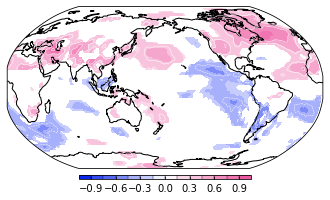

In [19]:
fig = plt.figure(figsize = (6,3))
ax = fig.add_subplot(1,1,1,projection = ccrs.Robinson(central_longitude=180))
ax.set_extent([0,359,-90,90], ccrs.PlateCarree())
ax.coastlines(resolution="110m")

ax.contour(lon2d, lat2d, corr, colors = 'w',linewidths=0.5, transform = ccrs.PlateCarree())
image = ax.contourf(lon2d, lat2d, corr, contourlevels, cmap=cmap_new, transform = ccrs.PlateCarree())

caxes = fig.add_axes([0.3,0.1,0.4,0.02])
cbar = plt.colorbar(image, orientation="horizontal", cax=caxes, drawedges = True)
cbar.ax.tick_params(direction="in")

plt.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.9, wspace=0, hspace=0)

filename_fig = "Corr_AMO_Tsfc.png"
plt.savefig(filename_fig)

In [20]:
lon.shape

(144,)

In [21]:
lon2d.shape

(73, 144)

#### **scipy.stats.pearsonr 함수 사용하기

In [22]:
prsn_r = np.zeros((nlat, nlon), np.float32)
prsn_p = np.zeros((nlat, nlon), np.float32)

for i in range(nlat):
    for j in range(nlon):
        prsn_r[i][j], prsn_p[i][j] =  pearsonr(AMO_short, air_yearmean_short[:,i,j])
        
        #r : It is the Pearson correlation coefficient. It shows the degree of relationship between x and y.
        #p value: It is the probability significance value. It checks whether to accept or reject the null hypothesis.

#print(r)
#print(p)
prsn_r #correlation coefficeint
prsn_p

array([[0.12326098, 0.12326098, 0.12326098, ..., 0.12326098, 0.12326098,
        0.12326098],
       [0.2700303 , 0.27828616, 0.2849878 , ..., 0.24796958, 0.25562072,
        0.26299044],
       [0.35609087, 0.38439438, 0.41183168, ..., 0.26836184, 0.29729995,
        0.32714137],
       ...,
       [0.6793844 , 0.61829627, 0.5674431 , ..., 0.91482913, 0.8302405 ,
        0.75105006],
       [0.8399725 , 0.8316184 , 0.82008636, ..., 0.8505656 , 0.8501348 ,
        0.8458465 ],
       [0.05916192, 0.05916192, 0.05916192, ..., 0.05916192, 0.05916192,
        0.05916192]], dtype=float32)

In [23]:
index_insignificant2 = (prsn_p>0.05)

In [24]:
prsn_r[index_insignificant2]=np.nan
prsn_r

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

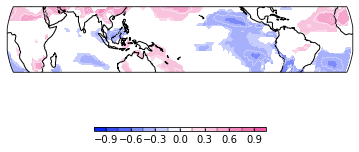

In [25]:
fig = plt.figure(figsize = (6,3))
ax = fig.add_subplot(1,1,1,projection = ccrs.Robinson(central_longitude=180))
ax.set_extent([0,359,-30,30], ccrs.PlateCarree())
ax.coastlines(resolution="110m")

ax.contour(lon2d, lat2d, prsn_r, colors = 'w',linewidths=0.5, transform = ccrs.PlateCarree())
image = ax.contourf(lon2d, lat2d, prsn_r, contourlevels, cmap=cmap_new, transform = ccrs.PlateCarree())

caxes = fig.add_axes([0.3,0.1,0.4,0.02])
cbar = plt.colorbar(image, orientation="horizontal", cax=caxes, drawedges = True)
cbar.ax.tick_params(direction="in")

plt.subplots_adjust(top=0.9, bottom=0.15, left=0.1, right=0.9, wspace=0, hspace=0)

filename_fig = "Corr_AMO_Tsfc.png"
plt.savefig(filename_fig)

## 3-7-3-. 극평사투영법 (Polar stereographic)

In [26]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

In [27]:
cenlon = -100
minlat=15
maxlat=90
textlat = minlat-15
textlon = cenlon

In [28]:
def get_anom(varname, plevel):
    global minlat
    
    file_clim = Dataset(varname+".mon.ltm.1981-2010.nc","r")
    lon = np.squeeze(file_clim.variables['lon'][:])
    lat = np.squeeze(file_clim.variables['lat'][:])
    level = np.squeeze(file_clim.variables['level'][:])
    pindex = np.where(level==plevel)[0]
    var_clim = np.squeeze(file_clim.variables[varname][0, pindex,:,:]) #1월 평균
    
    file_var = Dataset(varname+".1981.nc","r")
    var = np.squeeze(np.mean(file_var.variables[varname][:14,pindex,:,:], axis =0))
    print(np.shape(var_clim))
    
    var_anom=var - var_clim
    var_anom[lat<minlat,:] = np.nan
    return(lon, lat, var_anom)

In [29]:
def plot_PNA_pattern(varname, plevel, title, contour_levels, explanation):
    
    lon, lat, var_anom = get_anom(varname, plevel)
    
    if varname == "air":
        var_anom -=273.25
        
    jet = cm.get_cmap('jet',100)
    jet = jet(np.arange(100))
    white = np.array([1.,1.,1.,1])
    jet[45:56,:] = white
    new_cmap = ListedColormap(jet)
    
    fig, ax = plt.subplots(1,1)
    
    ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude= cenlon))
    ax.set_extent([-180,180, minlat, maxlat], ccrs.PlateCarree())
    #gl = ax.gridlines()
    #gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth=1, color = 'k', linestyle = '--')
    gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth=1, color = 'k', linestyle = '--')
    
    #gl.xlocator = mticker.FixedLocator((cenlon-180, cenlon-90, cenlon, cenlon+90, cenlon+180))

    #gl.xlocator = MultipleLocator(30)
    
    ax.coastlines(resolution="110m")
    
    image = ax.contourf(lon, lat, var_anom, contour_levels, cmap = new_cmap, transform = ccrs.PlateCarree(), extend = 'both')
    
    caxes = fig.add_axes([0.85, 0.15, 0.015,0.7])
    cbar = plt.colorbar(image, orientation = 'vertical', ticks = contour_levels[::2], drawedges = True, cax = caxes)
    cbar.ax.tick_params(direction = 'in')
    cbar.ax.set_xticks([int(x) for x in contour_levels[::2]])
    #cbar.ax.set_xticklabels([str(x) for x in contour_levels[::2]])
    
    #ticks_loc = ax.get_xticks().tolist()
    #ax.set_xticklabels([int(x) for x in ticks_loc])
    
    
    theta = np.linspace(0, 2*np.pi, 144)
    #np.linspace = 1차원 배열 만들기
    center = [0.5,0.5]
    radius = 0.5
    points = np.array([np.cos(theta), np.sin(theta)]).T
    #transpose하기전 (2,144) 로 cos은 cos 끼리, sin은 sin 끼리 모여있음
    #transpose 하면 (cos, sin) 쌍으로 묶임.
    print(np.shape(points))
    circle=mpath.Path(points*radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    
    plt.suptitle(title, fontsize=15, y=0.95)
    ax.text(textlon, textlat, explanation, fontsize=8, ha = 'center', transform = ccrs.Geodetic())
    
    plt.subplots_adjust(top=0.85, bottom = 0.15, left = 0.1, right=0.9, wspace = 0.1, hspace = 0.1)
    
    filename_figure = varname + "anom_PNA.png"
    plt.savefig(filename_figure)
    

(73, 144)


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_31652/995550467.py:33: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_xticks([int(x) for x in contour_levels[::2]])


(144, 2)


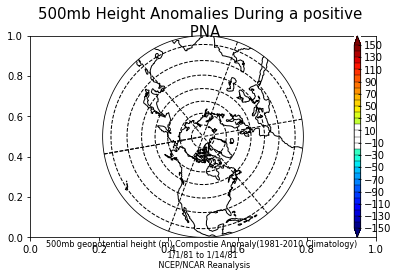

In [30]:
varname = "hgt"
title = "500mb Height Anomalies During a positive \n PNA"
contour_levels = np.arange(-150.,150.+10.,10.)
x = contour_levels[::2]
#print(len(contour_levels))

explanation = "500mb geopotential height (m) Compostie Anomaly(1981-2010 Climatology) \n 1/1/81 to 1/14/81 \n NCEP/NCAR Reanalysis"
plot_PNA_pattern(varname, 500, title, contour_levels, explanation)

(73, 144)
(144, 2)


C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_31652/995550467.py:33: UserWarning: Use the colorbar set_ticks() method instead.
  cbar.ax.set_xticks([int(x) for x in contour_levels[::2]])


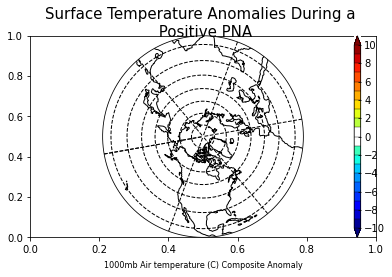

In [31]:
varname = "air"
title = "Surface Temperature Anomalies During a \n Positive PNA"
contour_levels = np.arange(-10., 10.+1., 1)
explanation = "1000mb Air temperature (C) Composite Anomaly"
plot_PNA_pattern(varname, 1000, title, contour_levels, explanation)

## 3-7-4. 람베르트 정각원추도법 (Lambert conformal)

In [32]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator

In [33]:
maptype="cartopy"

In [34]:
f = Dataset("wspd.mon.ltm.1981-2010.nc")
lat = np.squeeze(f.variables['lat'][:])
lon = np.squeeze(f.variables['lon'][:])
level = np.squeeze(f.variables['level'][:])
ind_level = np.where(level == 300)[0]

In [35]:
ind_winter = [0, 1, 11]
ind_summer = [5, 6, 7]

In [36]:
wspd_winter = np.mean(np.squeeze(f.variables['wspd'][ind_winter, ind_level, :, :]), axis =0)
wspd_summer = np.mean(np.squeeze(f.variables['wspd'][ind_summer, ind_level, : ,:]), axis =0)

In [37]:
wspd = np.stack((wspd_winter,wspd_summer))

In [38]:
lon2d, lat2d = np.meshgrid(lon, lat)
contour_levels = np.arange(0, 80+10,10)
titles = ["DJF", "JJA"]

In [39]:
lon_0 = 120
lat_0 = 45
width = 1.2e7
height = 7e6

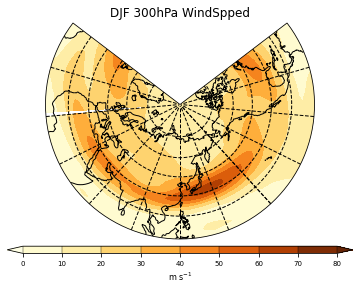

In [48]:
fig = plt.figure(figsize=(6,4))

if maptype == "Basemap":
    m = Basemap(projection = 'lcc', resolution = 'l', lon_0 = lon_0, lat_0 = lat_0, width= width, height = height)
    m.drawparallels(np.arange(-90,90+15,15), labels = [1,0,0,0], fontsize=7)
    m.drawmeridians(np.arange(0,360+30,30), labels = [0,0,0,1], fontsize=7)
    m.drawcoastlines()
    m.drawmapboundary(linewidth=0)
    image = m.contourf(lon2d, lat2d, wspd_winter, contour_levels, cmap = "YlOrBr", extend = "both", latlon=True)
    plt.title("DJF 300hpa Wind Speed", fontsize=12)
    
    
elif maptype =="cartopy" :
    ax = fig.add_subplot(111,projection = ccrs.LambertConformal(central_longitude=lon_0, central_latitude=lat_0,
                                                               standard_parallels=(lat_0,lat_0), cutoff=0))
    #Standard parallels : Lines at which there is no distortion in the map projection. 
    # The one or two latitudes of correct scale.
    #Standard parallels are used in both conical and cylindrical projections.
    #https://url.kr/ecwbq2
    ax.coastlines()
    
    gl = ax.gridlines(crs = ccrs.PlateCarree(), linewidth=1, color = 'k', linestyle = '--')
    gl.xlocator = MultipleLocator(30) # 축 눈금위치를 특정 수의 배수로 설정. 간격 30
    gl.ylocator = MultipleLocator(15) #간격 15
    
    image = ax.contourf(lon2d, lat2d, wspd_winter, contour_levels, cmap="YlOrBr", extend = "both", transform = ccrs.PlateCarree())
    ax.set_title("DJF 300hPa WindSpped", fontsize=12)
    
caxes = fig.add_axes([0.1,0.1,0.8,0.025])
cbar = plt.colorbar(image, cax = caxes, orientation = 'horizontal', ticks = contour_levels, format = "%d", drawedges = True)
cbar.set_label(label = "m s$^{-1}$", size = 8)
cbar.ax.tick_params(labelsize = 7)

plt.subplots_adjust(top= 0.9, bottom = 0.15, left = 0.1, right = 0.9, wspace = 0., hspace = 0.)
plt.show()

## 3-7-5 위성투영법

In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from datetime import date, timedelta
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def get_ssta(year, month):
    f = Dataset("sst.mnmean.nc","r")
    lon = np.squeeze(f.variables["lon"][:])
    lat = np.squeeze(f.variables['lat'][:])
    time = np.squeeze(f.variables['time'][:])
    time = np.array([date(1800,1,1)+timedelta(days=x) for x in time])
    
    ind_time = np.where(time == date(year, month,1))[0]
    sst = np.squeeze(f.variables["sst"][ind_time,:,:])
    
    f = Dataset("sst.ltm.1971-2000.nc","r")
    sst_clim = np.squeeze(f.variables["sst"][month-1,:,:])
    
    ssta = sst - sst_clim
    return(lat, lon, ssta)

In [3]:
def create_new_RdBu():
    RdBu = cm.get_cmap("RdBu", 50)
    RdBu = RdBu(np.arange(50))
    blue = RdBu[49]
    bluewhite = RdBu[29]
    white = RdBu[24]
    whitered = RdBu[20]
    red = RdBu[0]
    
    new_RdBu = LinearSegmentedColormap.from_list("new_RdBu", [blue, bluewhite, white, whitered, red],N = 256)
    
    return(new_RdBu)

In [10]:
def plot_ssta():
    
    lat, lon, ssta_Dec2015 = get_ssta(2015,12)
    _, _, ssta_Dec1999 = get_ssta(1999,12)
    
    ssta = np.stack([ssta_Dec2015, ssta_Dec1999])
    
    lon2d, lat2d = np.meshgrid(lon,lat)
    contour_levels = np.arange(-3,3+0.01,0.01)
    titles = ["El Nino \n December 2015", "La Nina \n December 1999"]
    

    new_RdBu = create_new_RdBu()
    
    #원하는 등고선 범위 넘지 않게 조작.
    #ssta[ssta >=contour_levels[-1]] = contour_levels[-2]
    #ssta[ssta <= contour_levels[0]] = contour_levels[1]
    
    fig = plt.figure(figsize=(8,4))
    fig.patch.set_facecolor("black")
    for i in range(2):
        fig.add_subplot(1,2,i+1)
        
        m = Basemap(projection = "ortho", resolution = 'l',
                   lon_0 = 220, lat_0 = 20)
        
        m.drawparallels([0])
        m.drawcoastlines()
        m.fillcontinents(color = 'gray')
        
        image = m.contourf(lon2d, lat2d, ssta[i,:,:], cmap = new_RdBu, extend = 'neither', latlon = True)
        
        plt.title(titles[i], fontsize = 10, color = 'white')
        
    caxes = fig.add_axes([0.37,0.1,0.26,0.03])        
    cbar = plt.colorbar(image, cax = caxes, orientation = 'horizontal', format = "%.1f")
    cbar.ax.set_title("Sea Surface Temperatrue Anomaly ($^{\circ}$C)", fontsize=7, color='white', verticalalignment='top', pad=0.5)
    cbar.ax.tick_params(labelsize = 7, length =0, labelcolor = "white")
    cbar.outline.set_edgecolor("white")

    plt.subplots_adjust(top=0.9, bottom=0.1, left = 0.1, right = 0.9, wspace = 0.2, hspace = 0)
    plt.show()

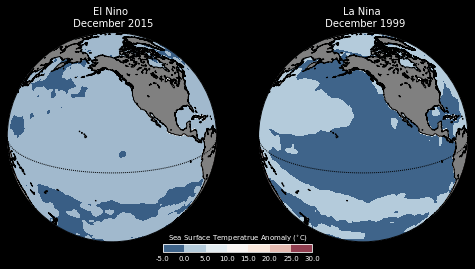

In [11]:
plot_ssta()

In [46]:
def plot_ssta():
    
    lat, lon, ssta_Dec2015 = get_ssta(2015,12)
    _, _, ssta_Dec1999 = get_ssta(1999,12)
    
    ssta = np.stack([ssta_Dec2015, ssta_Dec1999])
    
    lon2d, lat2d = np.meshgrid(lon,lat)
    contour_levels = np.arange(-3,3+0.01,0.01)
    titles = ["El Nino \n December 2015", "La Nina \n December 1999"]
    

    new_RdBu = create_new_RdBu()
    
     
    #ssta[ssta >=contour_levels[-1]] = contour_levels[-1]
    #ssta[ssta <= contour_levels[0]] = contour_levels[0]
    #print(ssta)
    print(np.min(ssta))
    print(np.max(ssta))
    
    fig = plt.figure(figsize=(8,4))
    fig.patch.set_facecolor("black")
    for i in range(2):
        fig.add_subplot(1,2,i+1)
        
        m = Basemap(projection = "ortho", resolution = 'l',
                   lon_0 = 220, lat_0 = 20)
        
        m.drawparallels([0])
        m.drawcoastlines()
        m.fillcontinents(color = 'gray')
        
        image = m.contourf(lon2d, lat2d, ssta[i,:,:], contour_levels, cmap = new_RdBu, extend = 'neither', latlon = True)
        
        plt.title(titles[i], fontsize = 10, color = 'white')
        
    caxes = fig.add_axes([0.37,0.1,0.26,0.03])        
    cbar = plt.colorbar(image, cax = caxes, orientation = 'horizontal', format = "%.1f")
    cbar.ax.set_title("Sea Surface Temperatrue Anomaly ($^{\circ}$C)", fontsize=7, color='white', verticalalignment='top', pad=0.5)
    cbar.ax.tick_params(labelsize = 7, length =0, labelcolor = "white")
    cbar.outline.set_edgecolor("white")

    plt.subplots_adjust(top=0.9, bottom=0.1, left = 0.1, right = 0.9, wspace = 0.2, hspace = 0)
    plt.show()

-4.05
31.109999


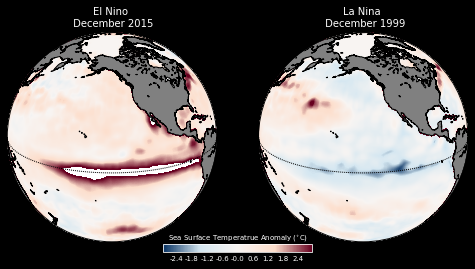

In [47]:
plot_ssta()